In [1]:
# Only run this once
import os
os.chdir('..')

In [2]:
import numpy as np
import scipy
from scipy import signal
import mne
import glob
import HiguchiFractalDimension as hfd
import csv
import matplotlib.pyplot as plt
from matplotlib import colors

import utils.logger
from utils.experiments_classification import classify_nusvm_cross_valid, classify_nusvm_param_seach

In [3]:
import importlib
importlib.reload(utils.experiments_classification)
importlib.reload(utils.experiments_setup)

<module 'utils.experiments_setup' from 'D:\\etc\\uni\\yr5\\project\\workspace\\eeg-cnp-final-year-project\\utils\\experiments_setup.py'>

In [4]:
def patient_array_to_hfd(repetitions, window_start=None, window_size=500, step_size=1, k=7):
    '''
    Apply HFD to all repetitions from given patient; input shape [n_repetitions, n_channels, n_features]
    '''
    if window_start != None:
        print('Calculating HFD with window start', str(window_start), 'window size', str(window_size), 'step', str(step_size))
        return np.array([np.array([[hfd.hfd(channel[window_start:window_start+window_size:step_size], num_k=k)] for channel in repetition]) for repetition in repetitions])
    print('Calculating HFD over entire time series')
    return np.array([np.array([[hfd.hfd(channel, num_k=k)] for channel in repetition]) for repetition in repetitions])

# Apply HFD to datasets

In [5]:
# Returns relevant datasets (f.e. all right-hand recordings of healthy patients) as a list of np arrays
def get_datasets(patient_type_location, recording_type_expression):
    if recording_type_expression != l_new['extension']:
        sets_locations = glob.glob(patient_type_location + recording_type_expression + suffix)
    else:
        sets_locations = glob.glob(patient_type_location + recording_type_expression)
    
    sets = []
    for path in sets_locations: 
        sets.append(mne.io.read_epochs_eeglab(path))
        
    return np.array(np.array([(patient._data) for patient in sets]))


def get_channel_names(patient_type_location, recording_type_expression):
    '''
    Returns the list of channel names in order
    Only works if ALL chosen datasets use the same channels
    '''
    if recording_type_expression != l_new:
        sets_locations = glob.glob(patient_type_location + recording_type_expression + suffix)
    else:
        sets_locations = glob.glob(patient_type_location + recording_type_expression)
        
    return mne.io.read_epochs_eeglab(sets_locations[0]).ch_names
    

In [6]:
root = './../../'
suffix = '*.set'

location_healthy = root + 'data/raw/HV/*/'
location_pain = root + 'data/raw/PP/*/'
location_nopain = root + 'data/raw/PnP/*/'

location_pwp = root + 'data_new/raw/PwP/*/'
location_pdp = root + 'data_new/raw/PdP/*/'
location_pnp = root + 'data_new/raw/PnP/*/'


rh = {'name': 'RH', 'extension': '*_RH*'}
lh = {'name': 'LH', 'extension': '*_LH*'}
l_new = {'name': 'L', 'extension': '*_L.set'}   # NO SUFFIX
l_old = {'name': 'L', 'extension': '*_L_*'}

sets_healthy_rh = glob.glob(location_pdp + l_new['extension'])
sets_healthy_rh

['./../../data_new/raw/PdP\\PdP_3\\PdP_3_L.set',
 './../../data_new/raw/PdP\\PdP_4\\PdP_4_L.set',
 './../../data_new/raw/PdP\\PdP_5\\PdP_5_L.set',
 './../../data_new/raw/PdP\\PdP_6\\PdP_6_L.set',
 './../../data_new/raw/PdP\\PdP_7\\PdP_7_L.set']

In [76]:
limb = l_new

# PP/PNP
#pp_rh_raw = get_datasets(location_pain, limb['extension'])
#pnp_rh_raw = get_datasets(location_nopain, limb['extension'])
#hv_rh_raw = get_datasets(location_healthy, limb['extension'])

# PDP/pnp
pp_rh_raw = get_datasets(location_pdp, limb['extension'])
pnp_rh_raw = get_datasets(location_pnp, limb['extension'])
hv_rh_raw = get_datasets(location_pwp, limb['extension'])

Extracting parameters from ./../../data_new/raw/PdP\PdP_3\PdP_3_L.set...


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


55 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data_new/raw/PdP\PdP_4\PdP_4_L.set...
59 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


Ready.
Extracting parameters from ./../../data_new/raw/PdP\PdP_5\PdP_5_L.set...
50 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


Extracting parameters from ./../../data_new/raw/PdP\PdP_6\PdP_6_L.set...
56 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


Extracting parameters from ./../../data_new/raw/PdP\PdP_7\PdP_7_L.set...
59 matching events found


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data_new/raw/PnP\PnP_1\PnP_1_L.set...
54 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


Ready.
Extracting parameters from ./../../data_new/raw/PnP\PnP_3\PnP_3_L.set...
54 matching events found
No baseline correction applied


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data_new/raw/PnP\PnP_4\PnP_4_L.set...
44 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


Extracting parameters from ./../../data_new/raw/PnP\PnP_5\PnP_5_L.set...
57 matching events found
No baseline correction applied
Not setting metadata


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


0 projection items activated
Ready.
Extracting parameters from ./../../data_new/raw/PnP\PnP_7\PnP_7_L.set...
56 matching events found


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data_new/raw/PnP\PnP_8\PnP_8_L.set...
56 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


Ready.
Extracting parameters from ./../../data_new/raw/PnP\PnP_9\PnP_9_L.set...
48 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


Alternatively, use all limbs

In [8]:
limb = {'name': 'all_limbs'}

pp_rh_raw = get_datasets(location_pain, rh['extension'])
pnp_rh_raw = get_datasets(location_nopain, rh['extension'])

pp_lh_raw = get_datasets(location_pain, lh['extension'])
pnp_lh_raw = get_datasets(location_nopain, lh['extension'])

pp_l_raw = get_datasets(location_pain, l_old['extension'])
pnp_l_raw = get_datasets(location_nopain, l_old['extension'])

Extracting parameters from ./../../data/raw/PP\PP1\PP1_F1_RH_Removed_ICA.set...


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


57 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PP\PP10\PP10_F1_RH_Removed_ICA.set...


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


57 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PP\PP11\PP11_F1_RH_Removed_ICA.set...


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


59 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PP\PP2\PP2_F1_RH_Removed_ICA.set...
54 matching events found


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PP\PP3\PP3_F1_RH_Removed_ICA.set...


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


51 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PP\PP4\PP4_F1_RH_Removed_ICA.set...


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


58 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PP\PP5\PP5_F1_RH_Removed_ICA.set...


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


56 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PP\PP6\PP6_F1_RH_Removed_ICA.set...
32 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


Extracting parameters from ./../../data/raw/PP\PP7\PP7_F1_RH_Removed_ICA.set...


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


52 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PP\PP9\PP9_F1_RH_Removed_ICA.set...


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


54 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PnP\PnP1\PnP1_F1_RH_Removed_ICA.set...
50 matching events found
No baseline correction applied
Not setting metadata


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PnP\PnP2\PnP2_F1_RH_Removed_ICA.set...
54 matching events found


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PnP\PnP3\PnP3_F1_RH_Removed_ICA.set...
44 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


Ready.
Extracting parameters from ./../../data/raw/PnP\PnP4\PnP4_F1_RH_Removed_ICA.set...


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


55 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PnP\PnP5\PnP5_F1_RH_Removed_ICA.set...


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


50 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PnP\PnP6\PnP6_F1_RH_Removed_ICA.set...
55 matching events found


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PnP\PnP7\PnP7_F01_RH_Removed_ICA.set...


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


58 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PnP\PnP8\PnP8_F1_RH_Removed_ICA.set...
53 matching events found


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PnP\PnP9\PnP9_F1_RH_Removed_ICA.set...


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


54 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PP\PP1\PP1_F1_LH_Removed_ICA.set...


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


56 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PP\PP10\PP10_F1_LH_Removed_ICA.set...


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


60 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PP\PP11\PP11_F1_LH_Removed_ICA.set...


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


60 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PP\PP2\PP2_F1_LH_Removed_ICA.set...


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


54 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PP\PP3\PP3_F1_LH_Removed_ICA.set...
51 matching events found


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PP\PP4\PP4_F1_LH_Removed_ICA.set...


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


58 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PP\PP5\PP5_F1_LH_Removed_ICA.set...


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


55 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PP\PP6\PP6_F1_LH_Removed_ICA.set...
27 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PP\PP7\PP7_F1_LH_Removed_ICA.set...


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))
<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


53 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PP\PP9\PP9_F1_LH_Removed_ICA.set...


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


51 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PnP\PnP1\PnP1_F1_LH_Removed_ICA.set...
51 matching events found
No baseline correction applied
Not setting metadata


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PnP\PnP2\PnP2_F1_LH_Removed_ICA.set...
55 matching events found


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PnP\PnP3\PnP3_F1_LH_Removed_ICA.set...
43 matching events found
No baseline correction applied
Not setting metadata


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PnP\PnP4\PnP4_F1_LH_Removed_ICA.set...


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


57 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PnP\PnP5\PnP5_F1_LH_Removed_ICA.set...
54 matching events found


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PnP\PnP6\PnP6_F1_LH_Removed_ICA.set...
53 matching events found


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PnP\PnP7\PnP7_F01_LH_Removed_ICA.set...


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


59 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PnP\PnP8\PnP8_F1_LH_Removed_ICA.set...


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


58 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PnP\PnP9\PnP9_F1_LH_Removed_ICA.set...
50 matching events found
No baseline correction applied


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PP\PP1\PP1_F1_L_Removed_ICA.set...
57 matching events found


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PP\PP10\PP10_F1_L_Removed_ICA.set...


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


59 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PP\PP11\PP11_F1_L_Removed_ICA.set...


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


59 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PP\PP2\PP2_F1_L_Removed_ICA.set...


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


51 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PP\PP3\PP3_F1_L_Removed_ICA.set...


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


52 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PP\PP4\PP4_F1_L_Removed_ICA.set...


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


57 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PP\PP5\PP5_F1_L_Removed_ICA.set...


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


55 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PP\PP6\PP6_F1_L_Removed_ICA.set...
32 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


Ready.
Extracting parameters from ./../../data/raw/PP\PP7\PP7_F1_L_Removed_ICA.set...
52 matching events found


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PP\PP9\PP9_F1_L_Removed_ICA.set...


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


54 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PnP\PnP1\PnP1_F1_L_Removed_ICA.set...
50 matching events found


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PnP\PnP2\PnP2_F1_L_Removed_ICA.set...


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


57 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PnP\PnP3\PnP3_F1_L_Removed_ICA.set...
41 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


Ready.
Extracting parameters from ./../../data/raw/PnP\PnP4\PnP4_F1_L_Removed_ICA.set...


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


58 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PnP\PnP5\PnP5_F1_L_Removed_ICA.set...
50 matching events found


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PnP\PnP6\PnP6_F1_L_Removed_ICA.set...


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


53 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PnP\PnP7\PnP7_F01_L_Removed_ICA.set...


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


58 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PnP\PnP8\PnP8_F1_L_Removed_ICA.set...
50 matching events found


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../data/raw/PnP\PnP9\PnP9_F1_L_Removed_ICA.set...


<ipython-input-5-a40508d617f2>:10: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


55 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.


In [78]:
pp_all_limbs = np.concatenate((pp_rh_raw, pp_lh_raw, pp_l_raw))
pnp_all_limbs = np.concatenate((pnp_rh_raw, pnp_lh_raw, pnp_l_raw))

NameError: name 'pp_lh_raw' is not defined

In [77]:
pnp_all_limbs.shape

NameError: name 'pnp_all_limbs' is not defined

In [79]:
ch_names_new = get_channel_names(location_pdp, rh['extension'])
ch_names_new

Extracting parameters from ./../../data_new/raw/PdP\PdP_1\PdP_1_RH.set...
65 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.


<ipython-input-5-a40508d617f2>:25: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  return mne.io.read_epochs_eeglab(sets_locations[0]).ch_names


['Fp1',
 'Fpz',
 'Fp2',
 'F7',
 'F3',
 'F1',
 'Fz',
 'F2',
 'F4',
 'F8',
 'FC3',
 'FC1',
 'FCz',
 'FC2',
 'FC4',
 'FC6',
 'T7',
 'C5',
 'C3',
 'C1',
 'Cz',
 'C2',
 'C4',
 'C6',
 'T8',
 'CP5',
 'CP3',
 'CP1',
 'CPz',
 'CP2',
 'CP4',
 'CP6',
 'P7',
 'P5',
 'P3',
 'P1',
 'Pz',
 'P2',
 'P4',
 'P6',
 'P8',
 'PO3',
 'POz',
 'PO4',
 'O1',
 'Oz',
 'O2',
 'FC5']

In [78]:
ch_names = get_channel_names(location_pain, rh['extension'])
ch_names

Extracting parameters from ./../../data/raw/PP\PP1\PP1_F1_RH_Removed_ICA.set...
57 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.


<ipython-input-5-a40508d617f2>:25: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  return mne.io.read_epochs_eeglab(sets_locations[0]).ch_names


['Cz',
 'C1',
 'C2',
 'C3',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'FCz',
 'FC1',
 'FC2',
 'FC3',
 'FC4',
 'FC5',
 'FC6',
 'FT7',
 'FT8',
 'CPz',
 'CP1',
 'CP2',
 'CP3',
 'CP4',
 'CP5',
 'CP6',
 'TP7',
 'TP8',
 'Fz',
 'F1',
 'F2',
 'F3',
 'F4',
 'F5',
 'F6',
 'F7',
 'F8',
 'Pz',
 'P1',
 'P2',
 'P3',
 'P4',
 'P5',
 'P6',
 'P7',
 'P8',
 'AFz',
 'AF3',
 'AF4',
 'AF7',
 'AF8',
 'Fp1',
 'FP2',
 'POz',
 'PO3',
 'PO4',
 'PO7',
 'PO8',
 'Oz',
 'O1',
 'O2',
 'Iz']

In [10]:
# Check for any channels not present in both
#for ch in ch_names_new:
#    if not (ch in ch_names):
 #       print(ch, end=' ')

In [11]:
pp_rh_raw.shape

(7,)

In [12]:
pp_rh_raw[4][3].shape

(48, 1280)

Rearrange as needed

In [13]:
def rearrange_channels(data, indices_rearranged):
    return np.array(list(map(lambda arr_p: np.array(list(map(lambda arr_r: arr_r[indices_rearranged], arr_p))), data)))

In [14]:
# PP/PNP

correct_order = np.array(['Fp1', 'FP2', 'AF7', 'AF3', 'AFz', 'AF4', 'AF8', 'F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'FT8', 'C7', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'C8', 'TP7', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'TP8', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'PO7','PO3', 'POz', 'PO4', 'PO8', 'O1', 'Oz', 'O2','Iz'])
current_order = np.array(ch_names)

In [15]:
# PDP/PNP

correct_order_new = np.array(['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F8', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'T7', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'T8', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'PO3', 'POz', 'PO4', 'O1', 'Oz', 'O2'])
current_order_new = np.array(ch_names_new)

In [16]:
ch_names_rearranged = correct_order.tolist()
ch_names_new_rearranged = correct_order_new.tolist()

In [17]:
# PP/PNP
indices_rearranged = [np.where(current_order == channel_name)[0][0] for channel_name in correct_order]

# PDP/PNP
indices_rearranged_new = [np.where(current_order_new == channel_name)[0][0] for channel_name in correct_order_new]

In [80]:
#pp_rh_raw_rearranged = rearrange_channels(pp_rh_raw, indices_rearranged)
#pnp_rh_raw_rearranged = rearrange_channels(pnp_rh_raw, indices_rearranged)
#hv_rh_raw_rearranged = rearrange_channels(hv_rh_raw, indices_rearranged)

pp_rh_raw_rearranged = rearrange_channels(pp_rh_raw, indices_rearranged_new)
pnp_rh_raw_rearranged = rearrange_channels(pnp_rh_raw, indices_rearranged_new)


In [81]:
pp_rh_raw_rearranged[0][0][13]

array([ 1.75000024e-06, -4.79167610e-07,  1.00000155e-06, ...,
       -7.35416651e-06, -9.77083397e-06, -8.06250095e-06])

In [82]:
pp_rh_raw[0][0][13]

array([ 3.75000024e-06,  2.52083373e-06,  3.00000000e-06, ...,
       -5.35416555e-06, -7.77083349e-06, -5.06250000e-06])

In [83]:
indices_rearranged_new

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 47,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46]

In [84]:
ch_names

['Cz',
 'C1',
 'C2',
 'C3',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'FCz',
 'FC1',
 'FC2',
 'FC3',
 'FC4',
 'FC5',
 'FC6',
 'FT7',
 'FT8',
 'CPz',
 'CP1',
 'CP2',
 'CP3',
 'CP4',
 'CP5',
 'CP6',
 'TP7',
 'TP8',
 'Fz',
 'F1',
 'F2',
 'F3',
 'F4',
 'F5',
 'F6',
 'F7',
 'F8',
 'Pz',
 'P1',
 'P2',
 'P3',
 'P4',
 'P5',
 'P6',
 'P7',
 'P8',
 'AFz',
 'AF3',
 'AF4',
 'AF7',
 'AF8',
 'Fp1',
 'FP2',
 'POz',
 'PO3',
 'PO4',
 'PO7',
 'PO8',
 'Oz',
 'O1',
 'O2',
 'Iz']

Get HFD over the set time window

In [85]:
window_start_sec = 3
window_size = 2
freq = 250

k = 7

In [108]:
pp_rh = np.array([patient_array_to_hfd(patient, window_start=int(window_start_sec*freq), window_size=window_size*freq, k=k) for patient in pp_rh_raw])
pnp_rh = np.array([patient_array_to_hfd(patient, window_start=int(window_start_sec*freq), window_size=window_size*freq, k=k) for patient in pnp_rh_raw])

Calculating HFD with window start 750 window size 500 step 1
Calculating HFD with window start 750 window size 500 step 1
Calculating HFD with window start 750 window size 500 step 1
Calculating HFD with window start 750 window size 500 step 1
Calculating HFD with window start 750 window size 500 step 1
Calculating HFD with window start 750 window size 500 step 1
Calculating HFD with window start 750 window size 500 step 1
Calculating HFD with window start 750 window size 500 step 1
Calculating HFD with window start 750 window size 500 step 1
Calculating HFD with window start 750 window size 500 step 1
Calculating HFD with window start 750 window size 500 step 1
Calculating HFD with window start 750 window size 500 step 1


OR get HFD for all limbs

In [16]:
pp_rh = np.array([patient_array_to_hfd(patient, window_start=int(window_start_sec*freq), window_size=window_size*freq, k=k) for patient in pp_all_limbs])
pnp_rh = np.array([patient_array_to_hfd(patient, window_start=int(window_start_sec*freq), window_size=window_size*freq, k=k) for patient in pnp_all_limbs])
#hv_rh = np.array([patient_array_to_hfd(patient, window_start=int(window_start_sec*freq), window_size=window_size*freq, k=k) for patient in hv_rh_limbs])

NameError: name 'pp_all_limbs' is not defined

Alternatively, get HFD over all windows of the specified size

In [86]:
pp_all_windows = [[patient_array_to_hfd(patient, window_start=window*freq, window_size=window_size*freq, k=k) for patient in pp_rh_raw_rearranged] for window in range(0,4)]
pnp_all_windows = [[patient_array_to_hfd(patient, window_start=window*freq, window_size=window_size*freq, k=k) for patient in pnp_rh_raw_rearranged] for window in range(0,4)]
#hv_all_windows = [[patient_array_to_hfd(patient, window_start=window*freq, window_size=window_size*freq, k=k) for patient in hv_rh_raw_rearranged] for window in range(0,4)]

Calculating HFD with window start 0 window size 500 step 1
Calculating HFD with window start 0 window size 500 step 1
Calculating HFD with window start 0 window size 500 step 1
Calculating HFD with window start 0 window size 500 step 1
Calculating HFD with window start 0 window size 500 step 1
Calculating HFD with window start 250 window size 500 step 1
Calculating HFD with window start 250 window size 500 step 1
Calculating HFD with window start 250 window size 500 step 1
Calculating HFD with window start 250 window size 500 step 1
Calculating HFD with window start 250 window size 500 step 1
Calculating HFD with window start 500 window size 500 step 1
Calculating HFD with window start 500 window size 500 step 1
Calculating HFD with window start 500 window size 500 step 1
Calculating HFD with window start 500 window size 500 step 1
Calculating HFD with window start 500 window size 500 step 1
Calculating HFD with window start 750 window size 500 step 1
Calculating HFD with window start 

In [87]:
np_all = np.array(pp_all_windows)

In [88]:
np.sum([s.shape[0] for s in np_all[0]])

279

In [89]:
pnp_rh.shape

NameError: name 'pnp_rh' is not defined

In [90]:
# Over individual patients
pp_all_windows_patients_repetitions = np.array([[np.array([[ channel[0] for channel in repetition ] for repetition in patient ]) for patient in window ] for window in np.array(pp_all_windows) ])
pnp_all_windows_patients_repetitions = np.array([[np.array([[ channel[0] for channel in repetition ] for repetition in patient ]) for patient in window ] for window in np.array(pnp_all_windows) ])
#hv_all_windows_patients_repetitions = np.array([[np.array([[ channel[0] for channel in repetition ] for repetition in patient ]) for patient in window ] for window in np.array(hv_all_windows) ])

pnp_all_windows_patients_repetitions.shape

(4, 7)

In [91]:
# All repetitions concatenated
pp_all_windows_repetitions = np.array([np.vstack([np.array([[ channel[0] for channel in repetition ] for repetition in patient ]) for patient in window ]) for window in np.array(pp_all_windows) ])
pnp_all_windows_repetitions = np.array([np.vstack([np.array([[ channel[0] for channel in repetition ] for repetition in patient ]) for patient in window ]) for window in np.array(pnp_all_windows) ])
#hv_all_windows_repetitions = np.array([np.vstack([np.array([[ channel[0] for channel in repetition ] for repetition in patient ]) for patient in window ]) for window in np.array(hv_all_windows) ])

pnp_all_windows_repetitions.shape

(4, 369, 48)

In [92]:
pp_mean_all_windows = np.mean(pp_all_windows_repetitions, axis=1).transpose()
pnp_mean_all_windows = np.mean(pnp_all_windows_repetitions, axis=1).transpose()
#hv_mean_all_windows = np.mean(hv_all_windows_repetitions, axis=1).transpose()

pnp_mean_all_windows.shape

(48, 4)

In [93]:
diff_pp_pnp_all_windows = pp_mean_all_windows - pnp_mean_all_windows
diff_pp_pnp_all_windows = diff_pp_pnp_all_windows - diff_pp_pnp_all_windows.mean()

#diff_hv_pnp_all_windows = hv_mean_all_windows - pnp_mean_all_windows
#diff_hv_pnp_all_windows = diff_hv_pnp_all_windows - diff_hv_pnp_all_windows.mean()

#diff_hv_pp_all_windows = hv_mean_all_windows - pp_mean_all_windows
#diff_hv_pp_all_windows = diff_hv_pp_all_windows - diff_hv_pp_all_windows.mean()

In [75]:
scipy.io.savemat('./results/arrays/hfd_2s_window_means_l.mat', {'pp': pp_mean_all_windows, 'pnp': pnp_mean_all_windows, 'hv': hv_mean_all_windows,
                                                                'diff_pp_pnp': diff_pp_pnp_all_windows, 'diff_hv_pnp': diff_hv_pnp_all_windows,
                                                                'diff_hv_pp': diff_hv_pp_all_windows})

In [34]:
scipy.io.savemat('./results/arrays/hfd_2s_window_individuals_lh.mat', {'pp': pp_all_windows_patients_repetitions, 'pnp': pnp_all_windows_patients_repetitions, 'hv': hv_all_windows_patients_repetitions,})

In [55]:
scipy.io.savemat('./results/arrays/hfd_2s_window_repetitions_l.mat', {'pp': pp_all_windows_repetitions, 'pnp': pnp_all_windows_repetitions, 'hv': hv_all_windows_repetitions,})

In [198]:
scipy.io.savemat('./results/arrays/pdp_hfd_2s_window_means_rearranged_rh.mat', {'pdp': pp_mean_all_windows, 'pnp': pnp_mean_all_windows,
                                                                'diff_pp_pnp': diff_pp_pnp_all_windows})

In [199]:
scipy.io.savemat('./results/arrays/pdp_hfd_2s_window_individuals_rearranged_rh.mat', {'pdp': pp_all_windows_patients_repetitions, 'pnp': pnp_all_windows_patients_repetitions})

In [200]:
scipy.io.savemat('./results/arrays/pdp_hfd_2s_window_repetitions_rearranged_rh.mat', {'pdp': pp_all_windows_repetitions, 'pnp': pnp_all_windows_repetitions})

In [219]:
testtt = scipy.io.loadmat('./results/arrays/pdp_pnp/pdp_hfd_2s_window_means_rh.mat')

In [217]:
testtt = scipy.io.loadmat('./results/arrays/pdp_pnp/pdp_hfd_2s_window_means_rearranged_rh.mat')

In [220]:
testtt['pdp'][47][0]

1.9336455249263929

In [132]:
(testtt['pdp'] - testtt['pnp']) - (testtt['pdp'] - testtt['pnp']).mean() - testtt['diff_pp_pnp']

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],


In [94]:
diff_all_windows = pp_mean_all_windows - pnp_mean_all_windows
diff_all_windows = diff_all_windows - diff_all_windows.mean()
diff_all_windows.shape

(48, 4)

In [95]:
scipy.stats.normaltest(diff_all_windows.flatten())

NormaltestResult(statistic=9.55005255869121, pvalue=0.00843786234303722)

In [96]:
#max_hfd = np.max([np.max(pp_mean_all_windows), np.max(pnp_mean_all_windows), np.min(hv_mean_all_windows)])
#min_hfd = np.min([np.min(pp_mean_all_windows), np.min(pnp_mean_all_windows), np.min(hv_mean_all_windows)])

# PDP/PNP
max_hfd = np.max([np.max(pp_mean_all_windows), np.max(pnp_mean_all_windows)])
min_hfd = np.min([np.min(pp_mean_all_windows), np.min(pnp_mean_all_windows)])

In [97]:
min_hfd

1.7468215138866106

In [98]:
np.mean(pnp_mean_all_windows)

1.880145510586833

In [99]:
np.mean(pp_all_windows_repetitions, axis=1).transpose()[14][1]

1.8889481743715624

In [153]:
graph_font_label = 19
graph_font_ticks = 15
graph_labels = ch_names_new_rearranged
n_channels = len(graph_labels)

cbar_fraction = 0.007
cbar_pad = 0.015
cbar_labelsize = 12

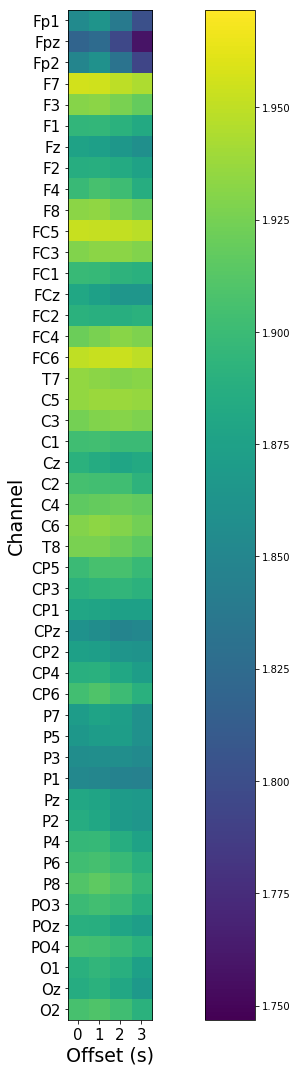

In [112]:
title = 'Normalized HFD values in ' + limb['name'] + ' within a 2s sliding window, PDP; k=7'
graph_name = 'window_pdp_' + limb['name']

plt.figure(figsize=[15,15])
#plt.title(title)
plt.ylabel('Channel', fontsize=graph_font_label)
plt.yticks(ticks=range(n_channels), labels=graph_labels, fontsize=graph_font_ticks)
plt.xticks(range(4), fontsize=graph_font_ticks)
plt.xlabel('Offset (s)', fontsize=graph_font_label)
plt.imshow(pp_mean_all_windows, vmin=min_hfd, vmax=max_hfd)
plt.tight_layout()
plt.colorbar()
plt.savefig('./results/graphs/rearranged_with_colourbars/v/' + limb['name'] + '/' + graph_name + '.eps', bbox_inches='tight')
plt.savefig('./results/graphs/rearranged_with_colourbars/v/' + limb['name'] + '/' + graph_name + '.jpg', bbox_inches='tight')

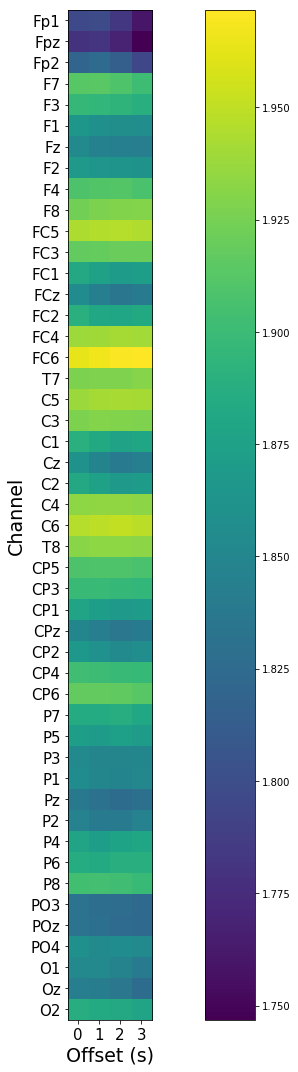

In [114]:
title = 'Normalized HFD values in ' + limb['name'] + ' within a 2s sliding window, PNP; k=7'
graph_name = 'window_pnp_' + limb['name']

plt.figure(figsize=[15,15])
#plt.title(title)
plt.ylabel('Channel', fontsize=graph_font_label)
plt.yticks(ticks=range(n_channels), labels=graph_labels, fontsize=graph_font_ticks)
plt.xticks(range(4), fontsize=graph_font_ticks)
plt.xlabel('Offset (s)', fontsize=graph_font_label)
plt.imshow(pnp_mean_all_windows, vmin=min_hfd, vmax=max_hfd)
plt.tight_layout()
plt.colorbar()
plt.savefig('./results/graphs/rearranged_with_colourbars/v/' + limb['name'] + '/' + graph_name + '.eps', bbox_inches='tight')
plt.savefig('./results/graphs/rearranged_with_colourbars/v/' + limb['name'] + '/' + graph_name + '.jpg', bbox_inches='tight')

NameError: name 'hv_mean_all_windows' is not defined

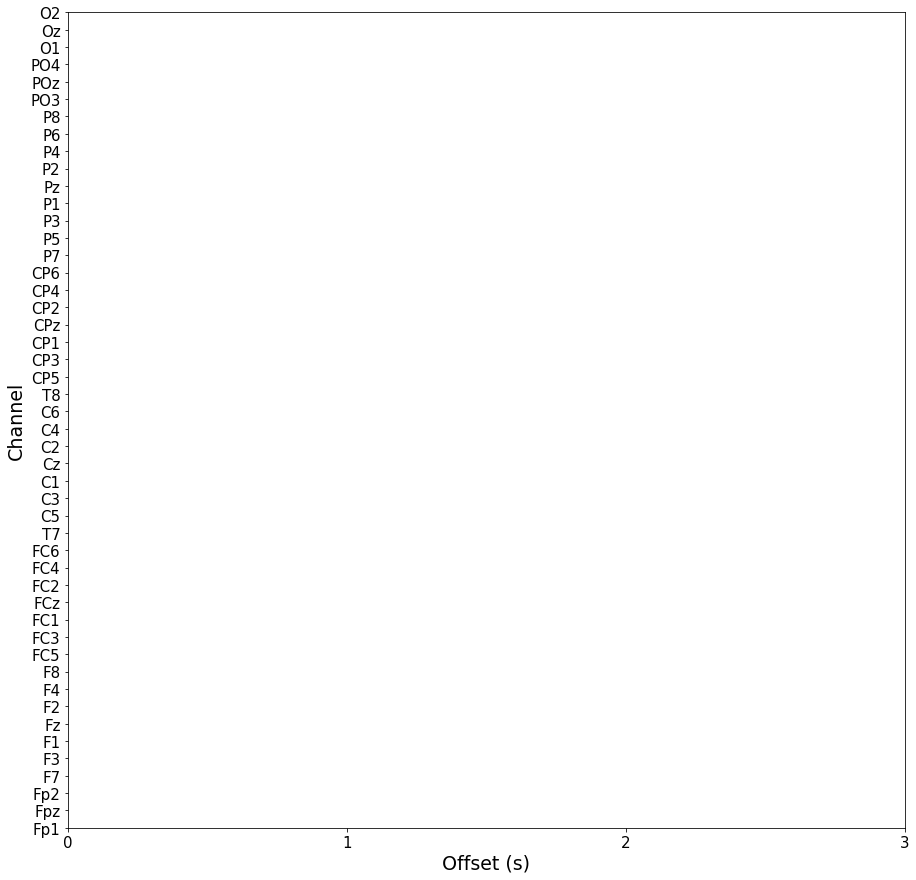

In [115]:
title = 'Normalized HFD values in ' + limb['name'] + ' within a 2s sliding window, PNP; k=7'
graph_name = 'window_hv_' + limb['name']

plt.figure(figsize=[15,15])
#plt.title(title)
plt.ylabel('Channel', fontsize=graph_font_label)
plt.yticks(ticks=range(n_channels), labels=graph_labels, fontsize=graph_font_ticks)
plt.xticks(range(4), fontsize=graph_font_ticks)
plt.xlabel('Offset (s)', fontsize=graph_font_label)
plt.imshow(hv_mean_all_windows, vmin=min_hfd, vmax=max_hfd)
plt.tight_layout()
plt.colorbar()
plt.savefig('./results/graphs/rearranged_with_colourbars/v/' + limb['name'] + '/' + graph_name + '.eps', bbox_inches='tight')
plt.savefig('./results/graphs/rearranged_with_colourbars/v/' + limb['name'] + '/' + graph_name + '.jpg', bbox_inches='tight')

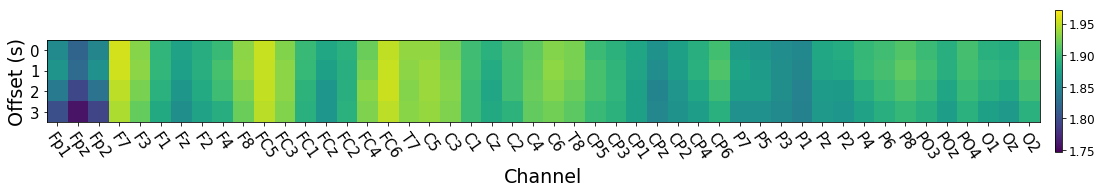

In [155]:
title = 'Normalized HFD values in ' + limb['name'] + ' within a 2s sliding window, PDP; k=7'
graph_name = 'window_pdp_' + limb['name']

plt.figure(figsize=[15,15])
#plt.title(title)
plt.xlabel('Channel', fontsize=graph_font_label)
plt.xticks(ticks=range(n_channels), labels=graph_labels, rotation=-55, fontsize=graph_font_ticks)
plt.yticks(range(4), fontsize=graph_font_ticks)
plt.ylabel('Offset (s)', fontsize=graph_font_label)
plt.imshow(pp_mean_all_windows.transpose(), vmin=min_hfd, vmax=max_hfd)
plt.tight_layout()
plt.colorbar(fraction=cbar_fraction, pad=cbar_pad).ax.tick_params(labelsize=cbar_labelsize)
plt.savefig('./results/graphs/rearranged_with_colourbars/h/' + limb['name'] + '/' + graph_name + '.eps', bbox_inches='tight')
plt.savefig('./results/graphs/rearranged_with_colourbars/h/' + limb['name'] + '/' + graph_name + '.jpg', bbox_inches='tight')

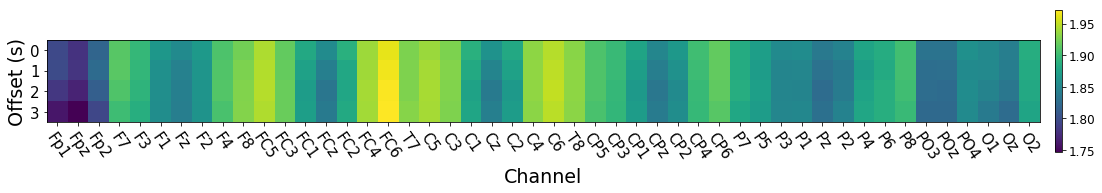

In [154]:
title = 'Normalized HFD values in ' + limb['name'] + ' within a 2s sliding window, PNP; k=7'
graph_name = 'window_pnp_' + limb['name']

plt.figure(figsize=[15,15])
#plt.title(title)
plt.xlabel('Channel', fontsize=graph_font_label)
plt.xticks(ticks=range(n_channels), labels=graph_labels, rotation=-55, fontsize=graph_font_ticks)
plt.yticks(range(4), fontsize=graph_font_ticks)
plt.ylabel('Offset (s)', fontsize=graph_font_label)
plt.imshow(pnp_mean_all_windows.transpose(), vmin=min_hfd, vmax=max_hfd)
plt.tight_layout()
plt.colorbar(fraction=cbar_fraction, pad=cbar_pad).ax.tick_params(labelsize=cbar_labelsize)
plt.savefig('./results/graphs/rearranged_with_colourbars/h/' + limb['name'] + '/' + graph_name + '.eps', bbox_inches='tight')
plt.savefig('./results/graphs/rearranged_with_colourbars/h/' + limb['name'] + '/' + graph_name + '.jpg', bbox_inches='tight')

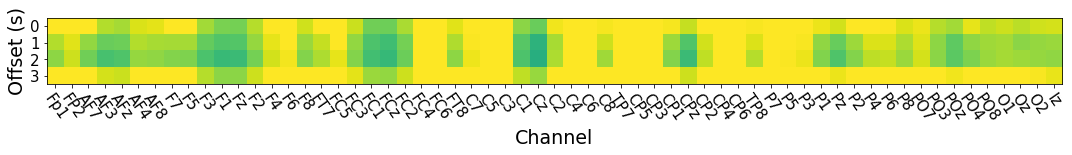

In [216]:
title = 'Normalized HFD values in ' + limb['name'] + ' within a 2s sliding window, PNP; k=7'
graph_name = 'window_hv_' + limb['name']

plt.figure(figsize=[15,15])
#plt.title(title)
plt.xlabel('Channel', fontsize=graph_font_label)
plt.xticks(ticks=range(n_channels), labels=graph_labels, rotation=-55, fontsize=graph_font_ticks)
plt.yticks(range(4), fontsize=graph_font_ticks)
plt.ylabel('Offset (s)', fontsize=graph_font_label)
plt.imshow(hv_mean_all_windows.transpose(), vmin=min_hfd, vmax=max_hfd)
plt.tight_layout()
plt.colorbar(fraction=cbar_fraction, pad=cbar_pad).ax.tick_params(labelsize=cbar_labelsize)
plt.savefig('./results/graphs/rearranged_with_colourbars/h/' + limb['name'] + '/' + graph_name + '.eps', bbox_inches='tight')
plt.savefig('./results/graphs/rearranged_with_colourbars/h/' + limb['name'] + '/' + graph_name + '.jpg', bbox_inches='tight')

In [217]:
diff_all_windows[ch_names.index('P1')]

array([-0.00362196,  0.00719893,  0.00538829, -0.0068483 ])

In [218]:
diff_all_windows.min()

-0.014372063369156874

In [219]:
asda = np.abs(diff_all_windows - np.zeros(diff_all_windows.shape))
np.unravel_index(asda.argmin(), asda.shape)

(25, 0)

In [220]:
ch_names[20]

'FCz'

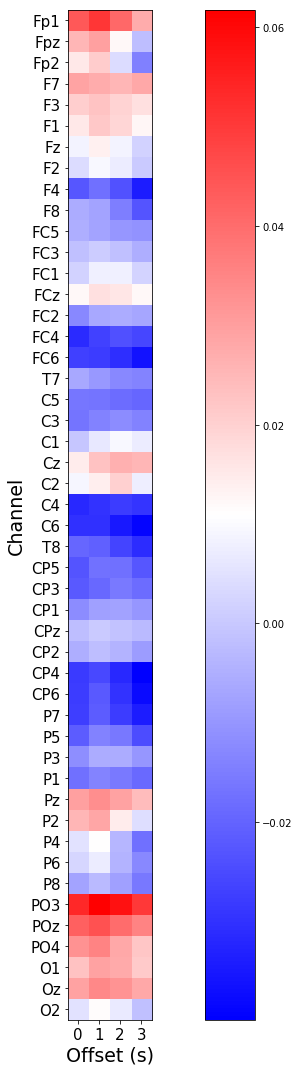

In [133]:
title = str('Normalized HFD difference in ' + limb['name'] + ' between PDP and PNP within a 2s sliding window; k=7\n' +
        'Red indicates PDP > PNP; Blue indicates PDP < PNP; white indicates similar values')
graph_name = 'window_pdp_pnp_diff_' + limb['name']

plt.figure(figsize=[15,15])
#plt.title(title)
plt.ylabel('Channel', fontsize=graph_font_label)
plt.yticks(ticks=range(n_channels), labels=graph_labels, fontsize=graph_font_ticks)
plt.xticks(range(4), fontsize=graph_font_ticks)
plt.xlabel('Offset (s)', fontsize=graph_font_label)
plt.imshow(diff_pp_pnp_all_windows, cmap='bwr')
plt.tight_layout()
plt.colorbar()
plt.savefig('./results/graphs/rearranged_with_colourbars/v/' + limb['name'] + '/' + graph_name + '.eps', bbox_inches='tight')
plt.savefig('./results/graphs/rearranged_with_colourbars/v/' + limb['name'] + '/' + graph_name + '.jpg', bbox_inches='tight')

NameError: name 'diff_hv_pp_all_windows' is not defined

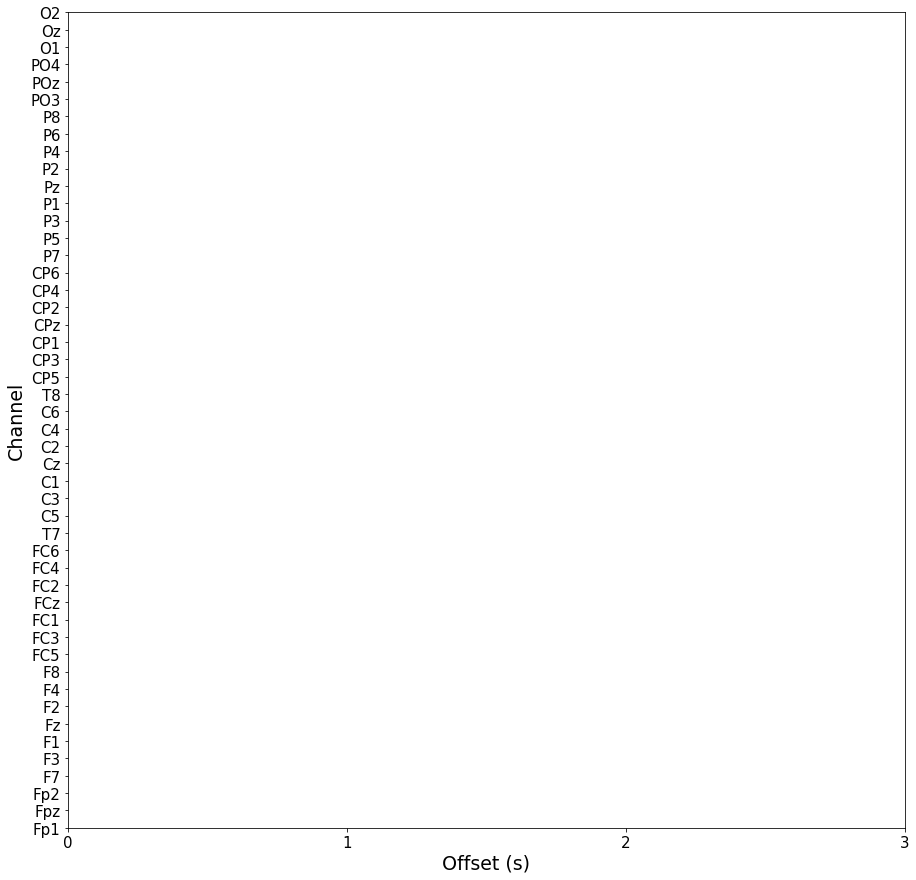

In [134]:
title = str('Normalized HFD difference in ' + limb['name'] + ' between PDP and PNP within a 2s sliding window; k=7\n' +
        'Red indicates PDP > PNP; Blue indicates PDP < PNP; white indicates similar values')
graph_name = 'window_hv_pp_diff_' + limb['name']

plt.figure(figsize=[15,15])
#plt.title(title)
plt.ylabel('Channel', fontsize=graph_font_label)
plt.yticks(ticks=range(n_channels), labels=graph_labels, fontsize=graph_font_ticks)
plt.xticks(range(4), fontsize=graph_font_ticks)
plt.xlabel('Offset (s)', fontsize=graph_font_label)
plt.imshow(diff_hv_pp_all_windows, cmap='bwr')
plt.tight_layout()
plt.colorbar()
plt.savefig('./results/graphs/rearranged_with_colourbars/v/' + limb['name'] + '/' + graph_name + '.eps', bbox_inches='tight')
plt.savefig('./results/graphs/rearranged_with_colourbars/v/' + limb['name'] + '/' + graph_name + '.jpg', bbox_inches='tight')

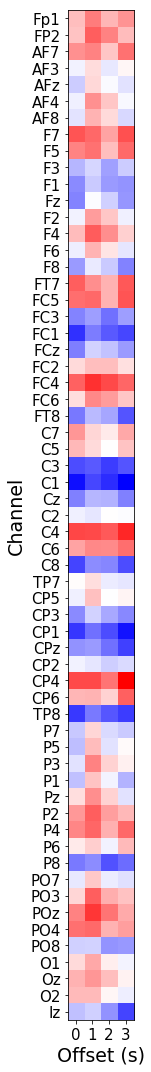

In [223]:
title = str('Normalized HFD difference in ' + limb['name'] + ' between PDP and PNP within a 2s sliding window; k=7\n' +
        'Red indicates PDP > PNP; Blue indicates PDP < PNP; white indicates similar values')
graph_name = 'window_hv_pnp_diff_' + limb['name']

plt.figure(figsize=[15,15])
#plt.title(title)
plt.ylabel('Channel', fontsize=graph_font_label)
plt.yticks(ticks=range(n_channels), labels=graph_labels, fontsize=graph_font_ticks)
plt.xticks(range(4), fontsize=graph_font_ticks)
plt.xlabel('Offset (s)', fontsize=graph_font_label)
plt.imshow(diff_hv_pnp_all_windows, cmap='bwr')
plt.tight_layout()
plt.colorbar()
plt.savefig('./results/graphs/rearranged_with_colourbars/v/' + limb['name'] + '/' + graph_name + '.eps', bbox_inches='tight')
plt.savefig('./results/graphs/rearranged_with_colourbars/v/' + limb['name'] + '/' + graph_name + '.jpg', bbox_inches='tight')

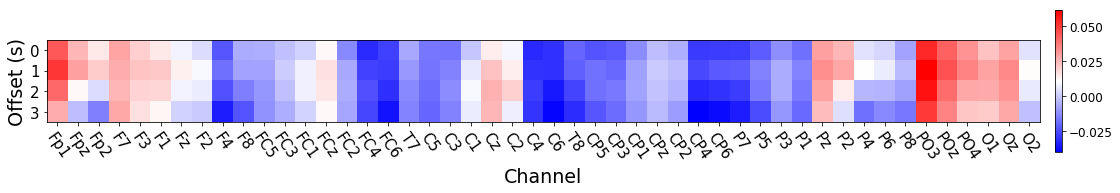

In [156]:
title = str('Normalized HFD difference in ' + limb['name'] + ' between PDP and PNP within a 2s sliding window; k=7\n' +
        'Red indicates PDP > PNP; Blue indicates PDP < PNP; white indicates similar values')
graph_name = 'window_pdp_pnp_diff_' + limb['name']

plt.figure(figsize=[15,15])
#plt.title(title)
plt.xlabel('Channel', fontsize=graph_font_label)
plt.xticks(ticks=range(n_channels), labels=graph_labels, rotation=-55, fontsize=graph_font_ticks)
plt.yticks(range(4), fontsize=graph_font_ticks)
plt.ylabel('Offset (s)', fontsize=graph_font_label)
plt.imshow(diff_pp_pnp_all_windows.transpose(), cmap='bwr')
plt.tight_layout()
plt.colorbar(fraction=cbar_fraction, pad=cbar_pad).ax.tick_params(labelsize=cbar_labelsize)
plt.savefig('./results/graphs/rearranged_with_colourbars/h/' + limb['name'] + '/' + graph_name + '.eps', bbox_inches='tight')
plt.savefig('./results/graphs/rearranged_with_colourbars/h/' + limb['name'] + '/' + graph_name + '.jpg', bbox_inches='tight')

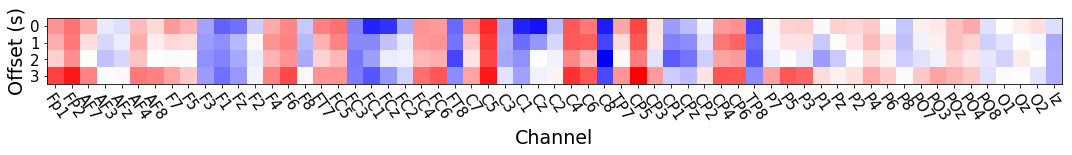

In [225]:
title = str('Normalized HFD difference in ' + limb['name'] + ' between PDP and PNP within a 2s sliding window; k=7\n' +
        'Red indicates PDP > PNP; Blue indicates PDP < PNP; white indicates similar values')
graph_name = 'window_hv_pp_diff_' + limb['name']

plt.figure(figsize=[15,15])
#plt.title(title)
plt.xlabel('Channel', fontsize=graph_font_label)
plt.xticks(ticks=range(n_channels), labels=graph_labels, rotation=-55, fontsize=graph_font_ticks)
plt.yticks(range(4), fontsize=graph_font_ticks)
plt.ylabel('Offset (s)', fontsize=graph_font_label)
plt.imshow(diff_hv_pp_all_windows.transpose(), cmap='bwr')
plt.tight_layout()
plt.colorbar(fraction=cbar_fraction, pad=cbar_pad).ax.tick_params(labelsize=cbar_labelsize)
plt.savefig('./results/graphs/rearranged_with_colourbars/h/' + limb['name'] + '/' + graph_name + '.eps', bbox_inches='tight')
plt.savefig('./results/graphs/rearranged_with_colourbars/h/' + limb['name'] + '/' + graph_name + '.jpg', bbox_inches='tight')

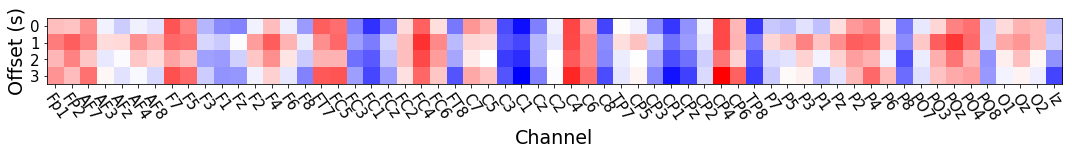

In [226]:
title = str('Normalized HFD difference in ' + limb['name'] + ' between PDP and PNP within a 2s sliding window; k=7\n' +
        'Red indicates PDP > PNP; Blue indicates PDP < PNP; white indicates similar values')
graph_name = 'window_hv_pnp_diff_' + limb['name']

plt.figure(figsize=[15,15])
#plt.title(title)
plt.xlabel('Channel', fontsize=graph_font_label)
plt.xticks(ticks=range(n_channels), labels=graph_labels, rotation=-55, fontsize=graph_font_ticks)
plt.yticks(range(4), fontsize=graph_font_ticks)
plt.ylabel('Offset (s)', fontsize=graph_font_label)
plt.imshow(diff_hv_pnp_all_windows.transpose(), cmap='bwr')
plt.tight_layout()
plt.colorbar(fraction=cbar_fraction, pad=cbar_pad).ax.tick_params(labelsize=cbar_labelsize)
plt.savefig('./results/graphs/rearranged_with_colourbars/h/' + limb['name'] + '/' + graph_name + '.eps', bbox_inches='tight')
plt.savefig('./results/graphs/rearranged_with_colourbars/h/' + limb['name'] + '/' + graph_name + '.jpg', bbox_inches='tight')

In [8]:
scipy.io.loadmat('./notebooks/Standard_10-10_61ch.mat')['None']

MatlabOpaque([(b'locations', b'MCOS', b'table', array([[3707764736],
       [         2],
       [         1],
       [         1],
       [         1],
       [         1]], dtype=uint32))],
             dtype=[('s0', 'O'), ('s1', 'O'), ('s2', 'O'), ('arr', 'O')])

In [22]:
pnp_rh[0].shape

(56, 48, 1)

In [23]:
pp_rh[3].shape

(58, 48, 1)

In [24]:
pp_and_pnp = np.concatenate((pp_rh, pnp_rh))
pp_and_pnp.shape

(14,)

For rearranging channels

In [45]:
example_1

array(['C', 'B', 'A'], dtype='<U1')

In [61]:
correct_order = np.array(['A', 'B', 'C'])
current_order = np.array(['B', 'C', 'A'])

In [65]:
indices_rearranged = [np.where(current_order == channel_name)[0][0] for channel_name in correct_order]
indices_rearranged

[2, 0, 1]

In [67]:
current_order

array(['B', 'C', 'A'], dtype='<U1')

In [66]:
current_order[indices_rearranged]

array(['A', 'B', 'C'], dtype='<U1')

In [48]:
pp_rh[0][0].shape

NameError: name 'pp_rh' is not defined

In [13]:
current_array = scipy.io.loadmat('./results/arrays/pp_pnp/hfd_2s_window_means_l.mat')
current_array['pp'].shape

(61, 4)

In [16]:
indices_rearranged = [np.where(current_order == channel_name)[0][0] for channel_name in correct_order]

In [18]:
pp_all_windows.shape

AttributeError: 'list' object has no attribute 'shape'

In [21]:
current_array['pp'][:, 0][indices_rearranged]

array([1.82944554, 1.82878706, 1.83018283, 1.83125091, 1.83098103,
       1.82870121, 1.83101779, 1.83156226, 1.83137508, 1.8343635 ,
       1.83543213, 1.83433073, 1.83306887, 1.83028393, 1.83023464,
       1.83527069, 1.83179804, 1.83265608, 1.83895252, 1.83867144,
       1.83747702, 1.83450789, 1.83494854, 1.83750561, 1.84212986,
       1.83478761, 1.83874968, 1.8455308 , 1.84053751, 1.83897644,
       1.83826811, 1.84252731, 1.84460197, 1.84802746, 1.83727167,
       1.83951499, 1.84295567, 1.84038728, 1.83525236, 1.83898306,
       1.84172011, 1.84065434, 1.84596539, 1.83687105, 1.83487019,
       1.83481768, 1.83419275, 1.82928853, 1.83263224, 1.83404899,
       1.83507887, 1.83595565, 1.83288887, 1.828805  , 1.8252163 ,
       1.82844504, 1.83278066, 1.8316504 , 1.82946538, 1.82987338,
       1.83418559])

In [31]:
current_array['pp'][:, 0]

array([1.83897644, 1.84053751, 1.83826811, 1.8455308 , 1.84252731,
       1.83874968, 1.84460197, 1.83478761, 1.84802746, 1.83747702,
       1.83867144, 1.83450789, 1.83895252, 1.83494854, 1.83265608,
       1.83750561, 1.83179804, 1.84212986, 1.83525236, 1.84038728,
       1.83898306, 1.84295567, 1.84172011, 1.83951499, 1.84065434,
       1.83727167, 1.84596539, 1.83433073, 1.83543213, 1.83306887,
       1.8343635 , 1.83028393, 1.83137508, 1.83023464, 1.83156226,
       1.83527069, 1.82928853, 1.83419275, 1.83263224, 1.83481768,
       1.83404899, 1.83487019, 1.83507887, 1.83687105, 1.83595565,
       1.83098103, 1.83125091, 1.82870121, 1.83018283, 1.83101779,
       1.82944554, 1.82878706, 1.8252163 , 1.828805  , 1.82844504,
       1.83288887, 1.83278066, 1.82946538, 1.8316504 , 1.82987338,
       1.83418559])

In [24]:
rearranged_pp = np.array(list(map(lambda arr_p: list(map(lambda arr_r: arr_r[indices_rearranged], arr_p)), 
                                  current_array['pp'])))

rearranged_pnp = np.array(list(map(lambda arr_p: list(map(lambda arr_r: arr_r[indices_rearranged], arr_p)),
                                   current_array['pnp'])))

rearranged_hv = np.array(list(map(lambda arr_p: list(map(lambda arr_r: arr_r[indices_rearranged], arr_p)), 
                                  current_array['hv'])))

IndexError: invalid index to scalar variable.

In [33]:
current_array['pp']

array([[1.83897644, 1.82553499, 1.81828744, 1.82901062],
       [1.84053751, 1.83220016, 1.82911756, 1.8365225 ],
       [1.83826811, 1.83160734, 1.83050417, 1.83659515],
       [1.8455308 , 1.84181306, 1.84117118, 1.8435972 ],
       [1.84252731, 1.8407325 , 1.84328354, 1.84419153],
       [1.83874968, 1.83603025, 1.83607544, 1.83825309],
       [1.84460197, 1.84165228, 1.84375297, 1.84441384],
       [1.83478761, 1.83169825, 1.83231813, 1.83689537],
       [1.84802746, 1.84289045, 1.84396678, 1.84641809],
       [1.83747702, 1.82499953, 1.82140901, 1.8342249 ],
       [1.83867144, 1.82960909, 1.82730345, 1.83834773],
       [1.83450789, 1.82711799, 1.82595639, 1.8344659 ],
       [1.83895252, 1.83507232, 1.83485829, 1.84113699],
       [1.83494854, 1.83404286, 1.83511943, 1.83606355],
       [1.83265608, 1.82853731, 1.82919994, 1.83527647],
       [1.83750561, 1.83545764, 1.83568792, 1.8370429 ],
       [1.83179804, 1.82663036, 1.82699349, 1.83354925],
       [1.84212986, 1.83803925,

In [28]:
current_array['pp'][indices_rearranged]

array([[1.82944554, 1.82526205, 1.82457858, 1.82976834],
       [1.82878706, 1.82515933, 1.824971  , 1.8288142 ],
       [1.83018283, 1.82590523, 1.82524586, 1.83198372],
       [1.83125091, 1.8272331 , 1.82562782, 1.83233561],
       [1.83098103, 1.82638388, 1.8251799 , 1.83113439],
       [1.82870121, 1.82502168, 1.82459914, 1.82846525],
       [1.83101779, 1.82816482, 1.8275618 , 1.83073418],
       [1.83156226, 1.82668807, 1.82656286, 1.83353084],
       [1.83137508, 1.82706557, 1.82672611, 1.83377203],
       [1.8343635 , 1.83033148, 1.8290557 , 1.83602418],
       [1.83543213, 1.82969295, 1.82776961, 1.8358847 ],
       [1.83433073, 1.82729797, 1.82586761, 1.83356363],
       [1.83306887, 1.82749648, 1.826941  , 1.83253437],
       [1.83028393, 1.82717514, 1.82751631, 1.83027231],
       [1.83023464, 1.82798146, 1.82793095, 1.83020749],
       [1.83527069, 1.83260344, 1.83188953, 1.83528294],
       [1.83179804, 1.82663036, 1.82699349, 1.83354925],
       [1.83265608, 1.82853731,

In [34]:
rearranged_pp = np.array(list(map(lambda arr_p: list(map(lambda arr_r: arr_r[indices_rearranged], arr_p)), 
                                  current_array['pp'])))

rearranged_pnp = np.array(list(map(lambda arr_p: list(map(lambda arr_r: arr_r[indices_rearranged], arr_p)),
                                   current_array['pnp'])))

rearranged_hv = np.array(list(map(lambda arr_p: list(map(lambda arr_r: arr_r[indices_rearranged], arr_p)), 
                                  current_array['hv'])))

IndexError: invalid index to scalar variable.

In [113]:
scipy.io.savemat('./results/arrays/hfd_2s_window_repetitions_rearranged_l.mat', {'pp': rearranged_pp, 'pnp': rearranged_pnp, 'hv': rearranged_hv})

In [114]:
testttt = scipy.io.loadmat('./results/arrays/pp_pnp/hfd_2s_window_repetitions_rearranged_l.mat')
testttt['pp'].shape

(4, 528, 61)

In [115]:
testttt['pp'][0][0]

array([1.84731532, 1.8360126 , 1.85882688, 1.85195306, 1.84423248,
       1.83537166, 1.82971399, 1.86868226, 1.87026202, 1.86946938,
       1.86157894, 1.84735954, 1.8393229 , 1.83176794, 1.82752963,
       1.82559224, 1.89022829, 1.8941037 , 1.88649916, 1.87650477,
       1.85378392, 1.83246668, 1.82341235, 1.8272976 , 1.82397022,
       1.89310203, 1.8857764 , 1.87722414, 1.8805008 , 1.868837  ,
       1.83548388, 1.83861148, 1.84039018, 1.83894312, 1.866221  ,
       1.87106163, 1.86712009, 1.8582025 , 1.85122382, 1.843322  ,
       1.8451434 , 1.84683443, 1.84644543, 1.84262577, 1.84455621,
       1.84624889, 1.84881723, 1.86954189, 1.87493845, 1.87481331,
       1.87239994, 1.86889409, 1.83523392, 1.83428848, 1.85251009,
       1.87778849, 1.87749486, 1.83813253, 1.84864046, 1.86412149,
       1.84426391])

(528, 1)

Plot histograms

In [20]:
# sample from two overlapping distributions (classes)

x0 = np.vstack(pnp_rh)[:, 26]
x1 = np.vstack(pp_rh)[:, 26]

mean0 = np.mean(x0)
mean1 = np.mean(x1)

range = [np.min([np.min(x0), np.min(x1)]), np.max([np.max(x0), np.max(x1)])]
print(mean0, mean1)

1.8961302461744058 1.8915257412494955


D:\etc\software\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6510: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


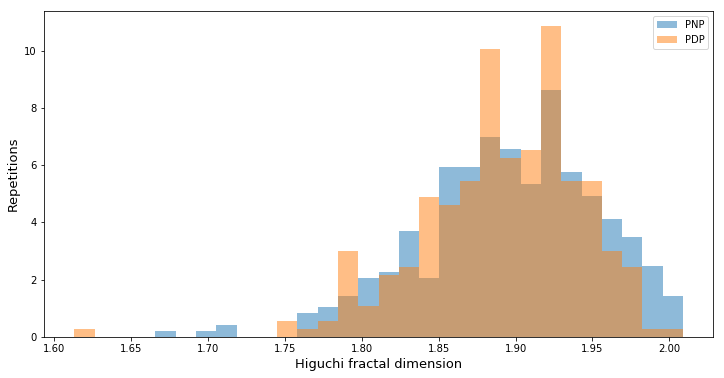

In [53]:
# plot histogram of each, using same bin delimiters and non-zero transparency

plt.figure(figsize=(12, 6))

_, bins, _ = plt.hist(x0, bins=30, range=range, alpha=0.5, normed=True)

plt.hist(x1, bins=bins, alpha=0.5, normed=True);

plt.xlabel('Higuchi fractal dimension', fontsize=13)
plt.ylabel('Repetitions', fontsize=13)
plt.legend(['PNP', 'PDP'])

plt.savefig('./results/graphs_etc/PDP_PNP_L_CP3_hist_norm.jpg', bbox_inches='tight')
plt.savefig('./results/graphs_etc/PDP_PNP_L_CP3_hist_norm.eps', bbox_inches='tight')

In [22]:
 # estimate accuracy of classifier with threshold half-way between means

threshold = (mean0 + mean1)/2

# assume x1 is positive and mean1 is higher

fp = np.sum(x0>=threshold)

fn = np.sum(x1<threshold)

accuracy = 1-(fp+fn)/(2*(len(x0) + len(x1)))

print("Accuracy:", accuracy)

Accuracy: 0.7445987654320987


In [23]:
pp_rh

array([array([[[1.88609379],
        [1.71198433],
        [1.82304706],
        ...,
        [1.78504494],
        [1.82568945],
        [2.0196318 ]],

       [[1.98630118],
        [1.87906954],
        [1.96253203],
        ...,
        [1.86150693],
        [1.91337665],
        [2.02122305]],

       [[1.88313373],
        [1.74318489],
        [1.84477828],
        ...,
        [1.84664474],
        [1.86682423],
        [2.00693083]],

       ...,

       [[1.69790035],
        [1.57746673],
        [1.60137938],
        ...,
        [1.71610943],
        [1.75725196],
        [2.00658309]],

       [[1.95627755],
        [1.88072121],
        [1.95448062],
        ...,
        [1.93364023],
        [1.88235008],
        [2.02494264]],

       [[1.73802306],
        [1.64613735],
        [1.75135353],
        ...,
        [1.78143155],
        [1.79499836],
        [1.99422218]]]),
       array([[[1.9877621 ],
        [1.98445638],
        [1.98545131],
        ...,
        [1.

In [31]:
x0.flatten().tolist()

[1.8903219430914342,
 1.8807569029343596,
 1.9013542933447398,
 1.8798902820167507,
 1.8970742646915366,
 1.8680312138269002,
 1.8842386639704027,
 1.9089061329720844,
 1.8101834096943712,
 1.926207989360454,
 1.9063441012245332,
 1.8887434811974608,
 1.8956859477335248,
 1.8547204956197805,
 1.9203985558463836,
 1.8841605023081165,
 1.893001842954505,
 1.909418543551268,
 1.9100653346995247,
 1.8485020236859193,
 1.9132729485553968,
 1.8874339910683617,
 1.7113000939343366,
 1.8668805975828002,
 1.8689560748755205,
 1.8970959629960322,
 1.9211514920827872,
 1.8269895263863152,
 1.894929679235232,
 1.9219611987477896,
 1.8882462210390607,
 1.7869288978639608,
 1.8597044943079974,
 1.9253822060811454,
 1.854706741414934,
 1.8885411213789451,
 1.875958764572405,
 1.9221376930604008,
 1.903400570116471,
 1.8595821307637903,
 1.9331288645768896,
 1.8884494889694035,
 1.8880343022210928,
 1.8851055207354706,
 1.8840587417767856,
 1.8775765739591672,
 1.8334996444997487,
 1.8947199091614044,

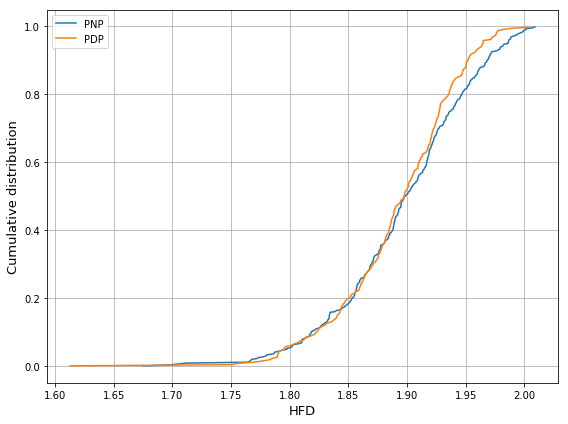

In [54]:
# sample from two overlapping distributions (classes)

N = 1000

 

# cumulative distributions of feature across trials in each group

# for example, 60% of trials in class 0 had 'HFD' below 0.3, and

# the same was true for only 20% of trials in class 1.

plt.figure(figsize=(8, 6))

plt.plot(np.sort(x0.flatten()), np.arange(len(x0))/len(x0), label='PNP')

plt.plot(np.sort(x1.flatten()), np.arange(len(x1))/len(x1), label='PDP')

plt.grid()

plt.xlabel('HFD', fontsize=13)

plt.ylabel('Cumulative distribution', fontsize=13)

plt.legend()

plt.tight_layout()

plt.savefig('./results/graphs_etc/PDP_PNP_L_CP3_cumulative.jpg', dpi=300, bbox_inches='tight')
plt.savefig('./results/graphs_etc/PDP_PNP_L_CP3_cumulative.eps', dpi=300, bbox_inches='tight')


# It's time to learn

In [96]:
log_proc_method = 'HFD'
log_dataset = 'PP/PNP-' + limb['name']
log_db_name = 'log.db'

log_notes = {'window start': window_start_sec, 'window size': window_size, 'k': k}

channel_names = ch_names_new if 'PDP' in log_dataset else ch_names

In [97]:
print(log_dataset)
print(log_notes)

PP/PNP-L
{'window start': 3, 'window size': 2, 'k': 7}


In [49]:
#For finding channel indices

channel_names_to_find = ['FC5']

find_in_pdp = True

for c in channel_names_to_find:
    if find_in_pdp:
        print(ch_names_new.index(c))
    else:
        print(ch_names.index(c))
        

47


In [43]:
ch_names[23]

'C4'

In [99]:
nu = 0.499999999
channels = [29]

acc, sensitivity, specificity, avg_acc = classify_nusvm_cross_valid(pp_rh, pnp_rh, nu, channels, channel_names,
                                                                    log_db_name=log_db_name,
                                                                    log_txt=True,
                                                                    log_proc_method=log_proc_method,
                                                                    log_dataset=log_dataset,
                                                                    log_notes=log_notes,
                                                                    log_details=True
                                                                   )
print('Accuracy', acc)
print('Sensitivity', sensitivity)
print('Specificity', specificity)
print('Average accuracy', avg_acc)

Test index 0 Test label 1 Preparing to classify set of 471 PP and 472 PNP.
Train score: 0.5058324496288441   Test score: 0.9473684210526315 Intercept: [22.44022485]
Test index 1 Test label 1 Preparing to classify set of 469 PP and 472 PNP.
Train score: 0.5015940488841658   Test score: 0.864406779661017 Intercept: [26.03980519]
Test index 2 Test label 1 Preparing to classify set of 469 PP and 472 PNP.
Train score: 0.5015940488841658   Test score: 1.0 Intercept: [-59.01411654]
Test index 3 Test label 1 Preparing to classify set of 477 PP and 472 PNP.
Train score: 0.5205479452054794   Test score: 0.8235294117647058 Intercept: [-80.06212758]
Test index 4 Test label 1 Preparing to classify set of 476 PP and 472 PNP.
Train score: 0.5042194092827004   Test score: 1.0 Intercept: [-16.01605346]
Test index 5 Test label 1 Preparing to classify set of 471 PP and 472 PNP.
Train score: 0.5153764581124072   Test score: 1.0 Intercept: [-15.16089946]
Test index 6 Test label 1 Preparing to classify set 

In [124]:
previous_channels=[]
nu = 0.5

max_acc = {'index': 0, 'value': 0}
for channel in range(len(channel_names)):        
    accuracy, sensitivity, specificity, avg_accuracy = classify_nusvm_cross_valid(pp_rh, pnp_rh, nu, 
                                                                                  previous_channels + [channel],
                                                                                  channel_names,
                                                                                  verbose=False,
                                                                                  log_db_name=log_db_name,
                                                                                  log_txt=True,
                                                                                  log_proc_method=log_proc_method,
                                                                                  log_dataset=log_dataset,
                                                                                  log_notes=log_notes
                                                                                 )
    print(channel, accuracy, sensitivity, specificity, avg_accuracy)
        
    if accuracy > max_acc['value']:
        max_acc['index'] = channel
        max_acc['value'] = accuracy

print('Max accuracy:', max_acc['index'], max_acc['value'])

0 0.5730994152046783 0.5216346153846154 0.6529850746268657 0.5831883649599486
1 0.5321637426900585 0.8269230769230769 0.07462686567164178 0.5097014793327518
2 0.5891812865497076 0.8677884615384616 0.15671641791044777 0.5666796768189957
3 0.6432748538011696 0.6995192307692307 0.5559701492537313 0.6417948393603695
4 0.631578947368421 0.6826923076923077 0.5522388059701493 0.6172820211455401
5 0.3406432748538012 0.10336538461538461 0.7089552238805971 0.36155131418289316
6 0.6388888888888888 0.5985576923076923 0.7014925373134329 0.64842966292748
7 0.5014619883040936 0.28125 0.8432835820895522 0.5118824684945175
8 0.6374269005847953 0.6153846153846154 0.6716417910447762 0.6332798668565336
9 0.47514619883040937 0.5769230769230769 0.31716417910447764 0.45895481618198336
10 0.42105263157894735 0.47836538461538464 0.332089552238806 0.43727168836495456
11 0.41812865497076024 0.47836538461538464 0.3246268656716418 0.43347915025662215
12 0.7251461988304093 0.8389423076923077 0.5485074626865671 0.70

In [90]:
channels = [26]

max_acc = {'index': 0, 'value': 0}
all_nu = []

for param in np.arange(0.1, 0.8, 0.025):    
    accuracy, sensitivity, specificity, avg_accuracy = classify_nusvm_cross_valid(pp_rh, pnp_rh, param,
                                                                                  channels,
                                                                                  channel_names,
                                                                                  verbose=False, 
                                                                                  log_db_name=log_db_name,
                                                                                  log_txt=True,
                                                                                  log_proc_method=log_proc_method,
                                                                                  log_dataset=log_dataset,
                                                                                  log_notes=log_notes
                                                                                 ) 
                                                      

    print(param, accuracy, sensitivity, specificity, avg_accuracy)
        
    all_nu.append({'nu': param, 'accuracy': accuracy})
        
    if accuracy > max_acc['value']:
        max_acc['index'] = param
        max_acc['value'] = accuracy

        
print('Max accuracy:', max_acc['index'], max_acc['value'])

0.1 0.41358024691358025 0.4157706093189964 0.41192411924119243 0.42056313581848825
0.125 0.5478395061728395 0.4946236559139785 0.5880758807588076 0.5384528504391722
0.15 0.5601851851851852 0.2831541218637993 0.7696476964769647 0.5740539749977008
0.175 0.5817901234567902 0.7491039426523297 0.45528455284552843 0.5859345810382831
0.19999999999999998 0.43364197530864196 0.8422939068100358 0.12466124661246612 0.4215052627931754
0.22499999999999998 0.39351851851851855 0.36917562724014336 0.41192411924119243 0.39635048823050606
0.24999999999999997 0.5262345679012346 0.6344086021505376 0.4444444444444444 0.5227146920545672
0.27499999999999997 0.4243827160493827 0.6702508960573477 0.23848238482384823 0.4089619858905096
0.29999999999999993 0.5416666666666666 0.6881720430107527 0.43089430894308944 0.525477654002037
0.32499999999999996 0.5648148148148148 0.5125448028673835 0.6043360433604336 0.5509199556129382
0.35 0.5154320987654321 0.46236559139784944 0.5555555555555556 0.507370723969371
0.37499

ValueError: specified nu is infeasible

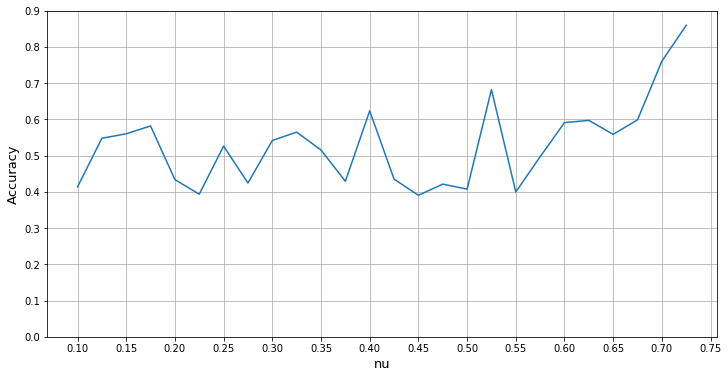

In [108]:
plt.figure(figsize=(12, 6))


plt.plot([i['nu'] for i in all_nu], [i['accuracy'] for i in all_nu])
plt.xlabel('nu', fontsize=13)
plt.ylabel('Accuracy', fontsize=13)
plt.yticks(np.arange(0.0, 1.0, 0.1))
plt.xticks(np.arange(0.1, 0.8, 0.05))

plt.grid()

plt.savefig('./results/graphs_etc/PDP_PNP_L_CP3_nu.jpg', bbox_inches='tight')
plt.savefig('./results/graphs_etc/PDP_PNP_L_CP3_nu.eps', bbox_inches='tight')

In [125]:
channel_names = ch_names_new if 'PDP' in log_dataset else ch_names

best_acc = classify_nusvm_param_seach(pp_rh, pnp_rh, 0.5, 0.501, 0.025, channel_names, constrain_channels=None,
                                      log_txt=True, log_proc_method=log_proc_method,
                                                                                  log_dataset=log_dataset,
                                                                                  log_notes=log_notes)

nu: 0.5
[45] 0.78
[45] 0.78
Max Accuracy: {'channels': [45], 'value': 0.7792397660818714, 'nu': 0.5}
Final Max Accuracy: {'channels': [45], 'value': 0.7792397660818714, 'nu': 0.5}


In [ ]:
best_acc